In [20]:
import numpy as np
import random
from rdkit import Chem
import matplotlib.pyplot as plt
from utils import load_dataset_df, fp_generator

#### Load DataFrame

In [21]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[0]
dirname = dt_file.removesuffix('.csv')

df, targets = load_dataset_df(filename=dt_file)

if dirname == 'tox21':
    # SR-ARE
    target_name = targets[7]
    # SR-MMP
elif dirname == 'sider':
    #Hepatobiliary disorders 1427 samples, 0.52 class ratio
    target_name = targets[0]
else:
    target_name = targets[0]
    
df = df[[target_name, 'smiles']].dropna()


#### Molecule to Fingerprint Vizualization

Clc1ccccc1-c1ccccc1Cl
18
1 ((3, 3), (10, 3))
64 ((3, 1), (4, 1), (9, 1), (10, 1))
103 ((2, 3), (11, 3))
175 ((3, 2), (4, 2), (9, 2), (10, 2))
297 ((4, 3), (9, 3))


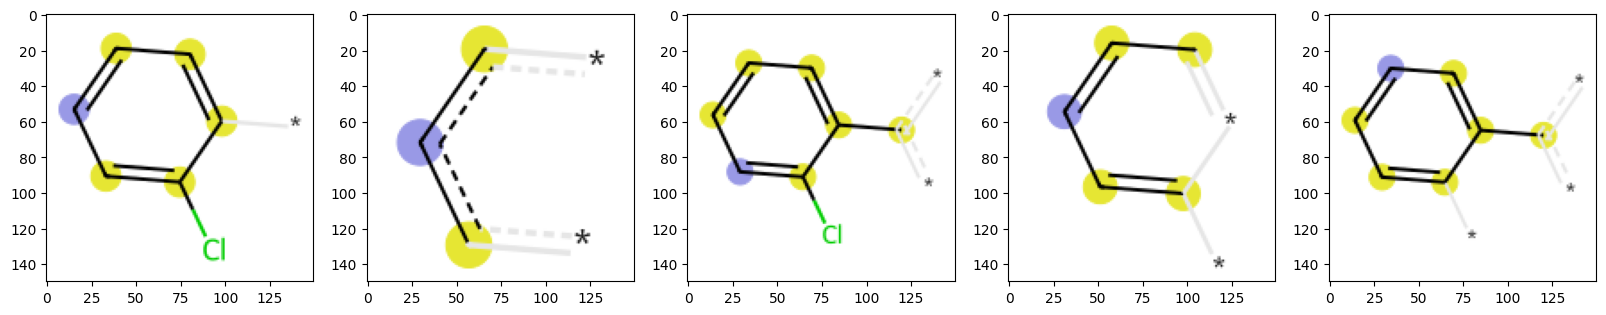

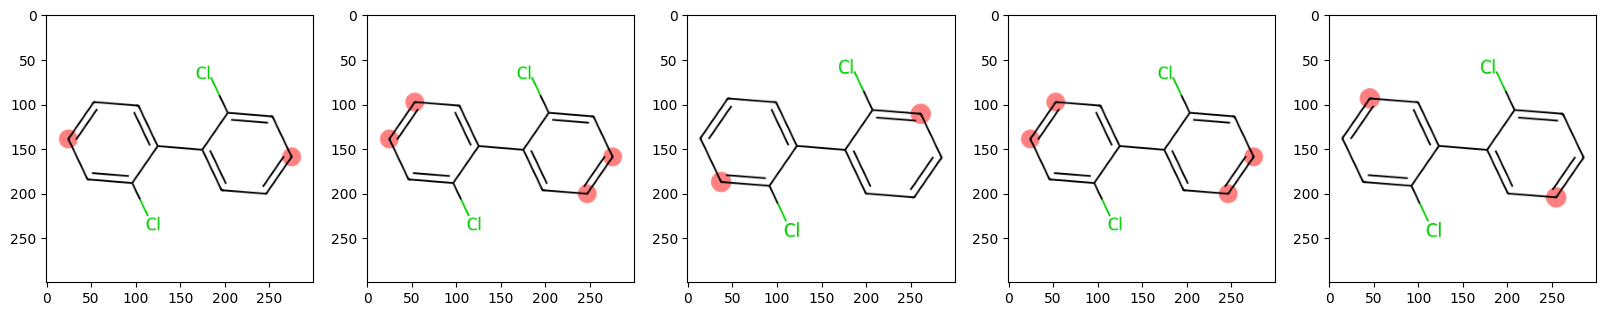

In [23]:
from rdkit.Chem import Draw, AllChem
from IPython.display import display


row = df.iloc[random.randint(0, len(df))]
print(row['smiles'])
mol = Chem.MolFromSmiles(row['smiles'])

if mol is not None:
    img = Draw.MolToImage(mol)

#TODO: (at a later point)
""" mol2 = Chem.RWMol(mol)
mol2 = mol2.RemoveAtom(1)

mol2 = Chem.MolToSmiles(mol2)
mol2 = Chem.SanitizeMol(mol2)


mol2 = Chem.Mol(mol2)
img2 = Draw.MolToImage(mol2)
display(img2) """

fpgen = fp_generator('morgan', radius=3)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()

fp = fpgen(mol,additionalOutput=ao) ## tentar converter para (#, #) e depois para bits
bi = ao.GetBitInfoMap()

fp = np.array(fp)
print(fp.sum())
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
fig2, axs2 = plt.subplots(1, 5, figsize=(20, 20))

for i, id in enumerate(list(bi.keys())[:5]):
    print(id, bi[id])
    mfp2_svg = Draw.DrawMorganBit(mol, bitId=id, bitInfo=bi)

    atoms = [info[0] for info in bi[id]]
    colors = {idx: (1, 1, 0) for idx in atoms}

    img2 = Draw.MolToImage(mol, highlightAtoms=atoms, highlightAtomColors=colors)
    
    axs[i].imshow(mfp2_svg)
    axs2[i].imshow(img2)


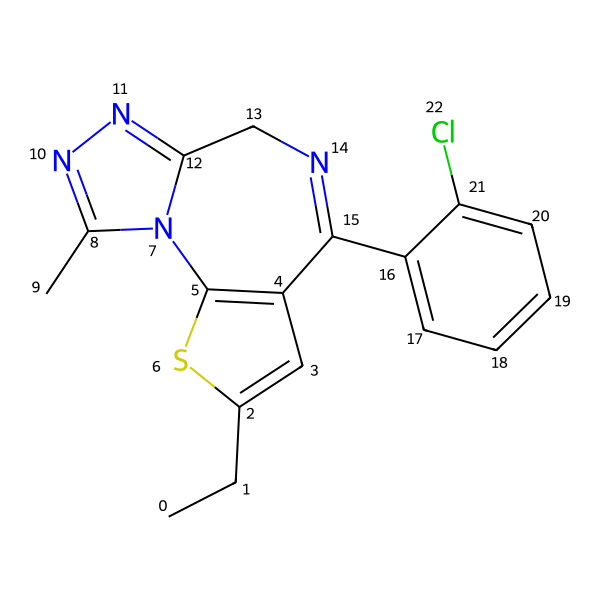

In [11]:
for i, atom in enumerate(mol.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    atom.SetProp("atomNote", f"{i}")
    
Draw.MolToImage(mol, size=(600, 600))

In [19]:
import torch
from torch.utils.data import TensorDataset
from utils import smile_to_fp

fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['pubchem', 881]]
mix = True
fp_type, num_bits = fp_types[0]
if mix: #Always use maccs + Morgan
    fp_type, num_bits = fp_types[1]
fp_config = {"fp_type": fp_type,
             "num_bits": num_bits,
             "radius": 2,
             "fp_type_2": fp_types[0][0],
             "num_bits_2": 1024 - num_bits,
             "mix": mix,
             }

print(fp_type, '-', num_bits)
dtype = torch.float32
split = "scaffold"
dataset = None


fp_array, target_array = smile_to_fp(df, fp_config=fp_config, target_name=target_name)

maccs - 167


[20:36:58] Explicit valence for atom # 8 Al, 6, is greater than permitted
[20:36:59] Explicit valence for atom # 3 Al, 6, is greater than permitted
[20:36:59] Explicit valence for atom # 4 Al, 6, is greater than permitted
[20:37:00] Explicit valence for atom # 4 Al, 6, is greater than permitted
[20:37:01] Explicit valence for atom # 9 Al, 6, is greater than permitted
[20:37:01] Explicit valence for atom # 5 Al, 6, is greater than permitted
[20:37:02] Explicit valence for atom # 16 Al, 6, is greater than permitted


In [13]:
import deepchem as dc

# Featurize the molecule using GraphConv
featurizer = dc.feat.ConvMolFeaturizer()
graph_feature = featurizer.featurize(["COC(=O)OC"])[0]

print(graph_feature.get_atom_features())  # Returns numerical atom feature array


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [27]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

mol = Chem.MolFromSmiles("COC(=O)OC")
gen = GetMorganGenerator(radius=4, fpSize=10, countSimulation=True)
fp = gen.GetFingerprint(mol)
print(fp)
fp = np.array(fp)
print(fp)
#for k in fp: print(k, end=',')

[1 1 0 0 1 1 1 1 0 0]


In [14]:
import deepchem as dc
from rdkit import Chem
import numpy as np

# Load Mol2Vec featurizer
mol2vec_featurizer = dc.feat.Mol2VecFingerprint()

# Example molecule
smiles = "CCO"  # Ethanol
mol = Chem.MolFromSmiles(smiles)

# Compute Mol2Vec embedding
mol2vec_embedding = mol2vec_featurizer.featurize([smiles])[0]

print("Mol2Vec Embedding Shape:", mol2vec_embedding.shape)
print("Mol2Vec Embedding:", mol2vec_embedding)


ImportError: This class requires mol2vec to be installed.

In [15]:
smiles = ['CC(=O)OC1=CC=CC=C1C(=O)O']
featurizer = dc.feat.MordredDescriptors(ignore_3D=True)
features = featurizer.featurize(smiles)

print("Mordred Descriptors:", features)

Failed to featurize datapoint 0, CC(=O)Oc1ccccc1C(=O)O. Appending empty array
Exception message: cannot import name 'Mapping' from 'collections' (C:\Users\knsve\.pyenv\pyenv-win\versions\3.10.0\lib\collections\__init__.py)


Mordred Descriptors: []
